In [ ]:
!pip install spacy-sentence-bert
!pip install scikit-learn
!python -m spacy download en_core_web_md
!pip install -U sentence-transformers
!pip install nlpaug

In [ ]:
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix

datasets_donwload_urllink = "https://drive.google.com/file/d/10dNvuX8Tk5xgoiCN3ohpyKzaFbYz-r8N/view?usp=drive_link"
file_id = '10dNvuX8Tk5xgoiCN3ohpyKzaFbYz-r8N'
user_interactions_url = f'https://drive.google.com/uc?id={file_id}'
topics_url = 'https://docs.google.com/spreadsheets/d/1FK1MxaY0U0KNxwXrAxbEfm4ylxWpY3o-QGiD5LpVK38/export?format=csv'

In [ ]:
nlp = spacy.load("en_core_web_md")

Helper Functions

In [ ]:
def anonymize_names_v2(doc):
    text = doc.text
    replacements = {}
    name_id = 1

    for ent in doc.ents:
        if ent.label_ == "PERSON":
            replacements[(ent.start_char, ent.end_char)] = f"[NAME_{name_id}]"
            name_id += 1

    # Sort from last to first to avoid offset shifting
    new_text = text
    for (start, end), placeholder in sorted(replacements.items(), reverse=True):
        new_text = new_text[:start] + placeholder + new_text[end:]

    return new_text, replacements

def deanonymize_text(text, mapping):
    reverse_mapping = {v: k for k, v in mapping.items()}
    for anon, original in reverse_mapping.items():
        text = text.replace(anon, original)
    return text
    # revert back code
    # Add a column with the reverted text
    # df['deanonymized'] = df.apply(lambda row: deanonymize_text(row['anonymized'], row['name_mapping']), axis=1)

def text_topic_similarity(text, topic):
    doc1 = nlp(text)
    doc2 = nlp(topic)

    return doc1.similarity(doc2)

In [ ]:
df = pd.read_csv(user_interactions_url)
df_topics = pd.read_csv(topics_url)

df.columns = ["rowid", "interaction", "label"]
df["anonymized_interaction"] = ''

### Perform Anonymization

In [ ]:
anonymized_results = []
replacement_maps = []

for doc in nlp.pipe(df['interaction'], batch_size=50):
    anonymized_text, mapping = anonymize_names_v2(doc)
    anonymized_results.append(anonymized_text)
    replacement_maps.append(mapping)

# Store results
df['anonymized_interaction'] = anonymized_results
df['name_mapping'] = replacement_maps

In [ ]:
df_anonymized = df[["rowid", "anonymized_interaction", "label"]]

### Perform Label evaluation and replacement

#### Before adding new label, evaluate original distribution and average confidence score with

In [ ]:
df_anonymized = df_anonymized.replace({'label':
    {
        "AccountDetails":"Account Details",
        "Loan":"Loan and Credit Services","HomeLoan":"Loan and Credit Services","AutoLoan":"Loan and Credit Services",
        "DebitCard":"Debit/Credit Card","CreditCard":"Debit/Credit Card",
        "Offers":"Product Inquiries",
        "Grievances":"Complaints",
        "TechSupport":"Technical Support"
    }
})
df_anonymized["original_label_confidence"] = 0

In [ ]:
from sentence_transformers import SentenceTransformer, util
from tqdm import tqdm
import torch
model = SentenceTransformer("all-MiniLM-L6-v2")

In [ ]:
# 1- Precompute text embeddings: text input
text_inputs = df_anonymized["anonymized_interaction"].tolist()
text_embeddings = model.encode(text_inputs, convert_to_tensor=True)

In [ ]:
# 2- compute original label confidence with sentence transformer and cosine sim
old_labels = df_anonymized["label"].tolist()
old_label_embeddings = model.encode(old_labels, convert_to_tensor=True)
old_labels_confidence_score = []

for i in range(len(text_embeddings)):
    sim = util.cos_sim(text_embeddings[i], old_label_embeddings[i])
    old_labels_confidence_score.append(sim.item())  # Convert 1x1 tensor to float

df_anonymized['original_label_confidence'] = old_labels_confidence_score

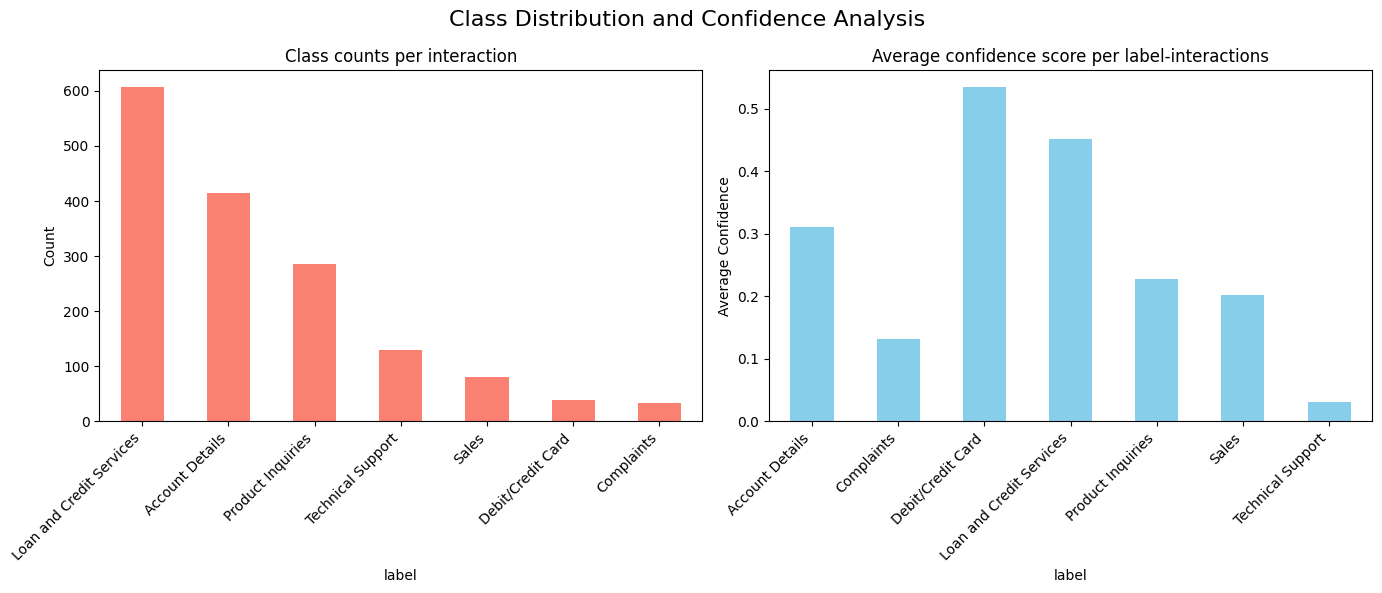

In [ ]:
# Label analysis on original datasets(anonymized) class distribution and average confidence per class
class_counts = df_anonymized['label'].value_counts()
old_avg = df_anonymized.groupby('label')['original_label_confidence'].mean()

# Create side-by-side bar charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Class Distribution and Confidence Analysis", fontsize=16)

# Plot class counts (left)
class_counts.plot(kind='bar', ax=ax1, color='salmon')
ax1.set_title("Class counts per interaction")
ax1.set_ylabel("Count")
ax1.set_xticklabels(class_counts.index, rotation=45, ha='right')

# Plot average confidence (right)
old_avg.plot(kind='bar', ax=ax2, color='skyblue')
ax2.set_title("Average confidence score per label-interactions")
ax2.set_ylabel("Average Confidence")
ax2.set_xticklabels(old_avg.index, rotation=45, ha='right')

plt.tight_layout()
plt.show()

#### Add new label with their confidence score

#### Zero shot classification with new topics

In [ ]:
df_anonymized["new_label"] = ""
df_anonymized["new_label_confidence"] = 0

In [ ]:
# 2- Precompute topics embeddings: new topics and text input
# topics_embeddings = model.encode(topics, convert_to_tensor=True) --- Old method
topic_embeddings = {}
for topic, group in df_topics.groupby("topic"):
    enriched_texts = (
        "Topic: " + group["topic"] +
        ". Description: " + group["description"] +
        " Example: " + group["example"]
    ).tolist()

    embeddings = model.encode(enriched_texts, convert_to_tensor=True)
    avg_embedding = torch.mean(embeddings, dim=0)
    topic_embeddings[topic] = avg_embedding


In [ ]:
# 4- compute new label confidence with sentence transformer and cosine sim using enricheds topics

# Step 1: Extract topic names and their averaged embeddings
topic_names = list(topic_embeddings.keys())  # e.g., ['Account Details', 'Product Inquiries', ...]
topic_avg_embeddings = torch.stack([topic_embeddings[topic] for topic in topic_names])  # shape: [num_topics, emb_dim]

# Step 2: Prepare to store results
predicted_topics = []
topics_confidence_scores = []

for text_emb in tqdm(text_embeddings):
    similarities = util.cos_sim(text_emb, topic_avg_embeddings)  # shape: [1, num_topics]
    best_idx = similarities.argmax().item()
    predicted_topics.append(topic_names[best_idx])
    topics_confidence_scores.append(similarities[0][best_idx].item())

# Step 3: save new labels and confidence score
df_anonymized["new_label"] = predicted_topics
df_anonymized["new_label_confidence"] = topics_confidence_scores

100%|██████████| 1588/1588 [00:00<00:00, 9713.98it/s]


In [ ]:
df_anonymized[["label", "original_label_confidence", "new_label", "new_label_confidence"]].head(2)

,label,original_label_confidence,new_label,new_label_confidence
0,Loan and Credit Services,0.504656,Loan and Credit Services,0.418912
1,Loan and Credit Services,0.432348,Loan and Credit Services,0.360671


### Label distribution and comparison

In [ ]:
#df_anonymized['new_label'].value_counts()
#df_anonymized['label'].value_counts()

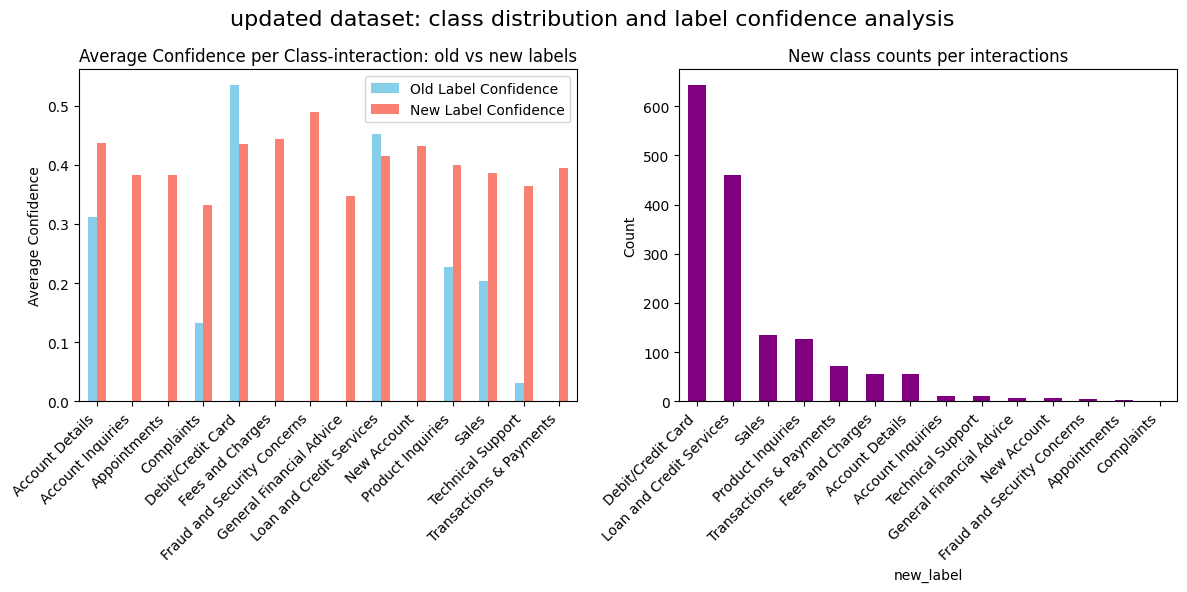

In [ ]:
new_class_counts = df_anonymized['new_label'].value_counts()
old_avg = df_anonymized.groupby('label')['original_label_confidence'].mean()
new_avg = df_anonymized.groupby('new_label')['new_label_confidence'].mean()

comparison_df = pd.DataFrame({
    'Old Label Confidence': old_avg,
    'New Label Confidence': new_avg
}).fillna(0)

# Create side-by-side bar charts
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig1.suptitle("updated dataset: class distribution and label confidence analysis", fontsize=16)

# Plot class counts (left)
new_class_counts.plot(kind='bar', ax=ax2, color='purple')
ax2.set_title("New class counts per interactions")
ax2.set_ylabel("Count")
ax2.set_xticklabels(new_class_counts.index, rotation=45, ha='right')

# Plot grouped bar chart (right)
import matplotlib.pyplot as plt
comparison_df.plot(kind='bar', ax=ax1, figsize=(12, 6), color=['skyblue', 'salmon'])
ax1.set_ylabel("Average Confidence")
ax1.set_title("Average Confidence per Class-interaction: old vs new labels")
ax1.set_xticklabels(comparison_df.index, rotation=45, ha='right')

plt.tight_layout()
plt.show()

### Deal with label imbalance: apply oversampling with data augmentation

In [ ]:
import nlpaug.augmenter.word as naw
import nltk
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('omw-1.4')  # For multilingual WordNet synonyms (optional but recommended)

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
majority_classes = ["Debit/Credit Card Issues","Loan and Credit Services",]
minority_classes = [topic for topic in df_anonymized['new_label'].unique() if topic not in majority_classes]

In [ ]:
df_anonymized = df_anonymized[["anonymized_interaction","new_label"]]
df_anonymized_minority = df_anonymized[df_anonymized['new_label'].isin(minority_classes)]
df_anonymized_majority = df_anonymized[~df_anonymized['new_label'].isin(minority_classes)]

In [ ]:
df_anonymized_majority.head(3)

,anonymized_interaction,new_label
0,"Hi [NAME_1], my name is [NAME_2]. What are the...",Loan and Credit Services
1,"Hi [NAME_1], my name is [NAME_2], How long doe...",Loan and Credit Services
2,"Hi [NAME_1], my name is [NAME_2], What docume...",Loan and Credit Services


In [ ]:
aug = naw.SynonymAug(aug_src='wordnet', model_path='en_core_web_md')

target = 450  # target_count_per_augmentation_perclass (mean or median of max class)
minority_counts = df_anonymized_minority['new_label'].value_counts()

repeats_per_class = {
    label: max((target - count) // count, 0)
    for label, count in minority_counts.items()
}

In [ ]:
augmented_texts = []
for label, group in df_anonymized_minority.groupby('new_label'):
    n_repeat = repeats_per_class[label]
    for _, row in group.iterrows():
        for _ in range(n_repeat):
            augmented_texts.append({
                "anonymized_interaction": aug.augment(row['anonymized_interaction']),
                "new_label": label
            })

In [ ]:
df_augmented = pd.DataFrame(augmented_texts)
df_balanced = pd.concat([df_anonymized_majority, df_anonymized_minority, df_augmented], ignore_index=True)
df_balanced = df_balanced.sample(frac=1).reset_index(drop=True)

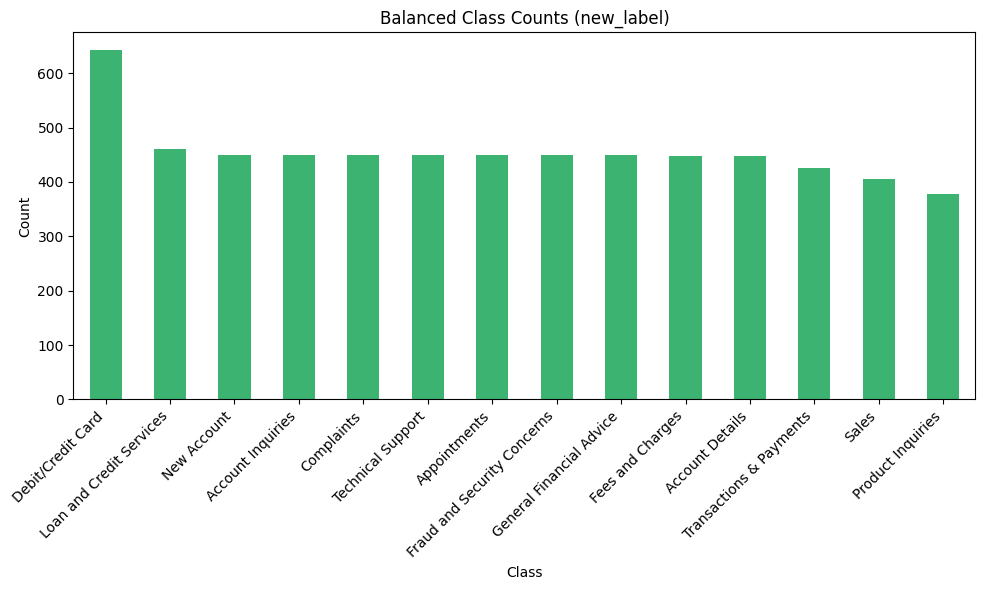

In [ ]:
balanced_class_counts = df_balanced['new_label'].value_counts()

# Plot the bar chart
plt.figure(figsize=(10, 6))
balanced_class_counts.plot(kind='bar', color='mediumseagreen')
plt.title("Balanced Class Counts (new_label)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()